## Aircraft Detection - Deep Learning Project

In [1]:
import os
import json
import random
import pandas as pd
import skimage.io
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

In [2]:
data_root = os.getcwd()
print(data_root)
#r"D:\RarePlanes\data"
train_imgs = os.path.join(data_root, r'data\train')
annot_dir = os.path.join(data_root, r'data\annot\rareplanes.json')
train_im_list = [z for z in os.listdir(train_imgs) if z.endswith('.png')]
f = open(annot_dir)
data = json.load(f)
print(len(train_im_list))
print(len(data['images']))
assert len(train_im_list) == len(data['images'])

def imgs_annot_aggregator(iter):
    print("Running imgs_annot_aggregator...")
    final = np.zeros((iter,4))
    bounding_boxes = []
    image_names = []
    instances_img = []
    amount_matches = []
    class_type = []
    for j in range(iter): 
        instances_img = []                        
        img = random.sample(train_im_list,1)
        image_names.append(img[0])
        for i in range(len(data['categories'])):
            if [data['categories'][i]['image_fname']] == img:
                instances_img.append(data['categories'][i]['id'])
        for l in range(len(instances_img)):
            for i in range(len(data['categories'])):
                if data['categories'][i]['id'] == instances_img[l]:
                    bounding_boxes.append(data['categories'][i]['bbox'])
                    class_type.append(data['categories'][i]['role'])
        amount_matches.append(len(instances_img))
    final = amount_matches, image_names, bounding_boxes, class_type
    return final, image_names

def bbox_points(data_annot):
    print("Running bbox_points...")
    name = []
    x_org = []
    y_org = []
    x_dist = []
    y_dist = []
    bbox = []
    class_type = []
    file_path = []
    itr = 0
    for i in range(len(data_annot[0])):
        for j in range(data_annot[0][i]):
            name.append(data_annot[1][i])
            class_type.append(data_annot[3][i])
            x_org.append(data_annot[2][j+itr][0])
            y_org.append(data_annot[2][j+itr][1])
            x_dist.append(data_annot[2][j+itr][2])
            y_dist.append(data_annot[2][j+itr][3])
            bbox.append([data_annot[2][j+itr][0],data_annot[2][j+itr][1],data_annot[2][j+itr][0]+data_annot[2][j+itr][2],data_annot[2][j+itr][1]+data_annot[2][j+itr][3]])
            file_path.append(os.path.join(train_imgs, data_annot[1][i]))
        itr = itr + data_annot[0][i]
    df = pd.DataFrame(
    {'name': name,
     'class': class_type,
     'x_org': x_org,
     'y_org': y_org,
     'x_dist': x_dist,
     'y_dist': y_dist,
     'bbox': bbox,
     'file_path': file_path
    })
    return df

final, img_name = imgs_annot_aggregator(1)
result = bbox_points(final)
result.head()

d:\RarePlanes
5815
5815
Running imgs_annot_aggregator...
Running bbox_points...


,name,class,x_org,y_org,x_dist,y_dist,bbox,file_path
0,18_1040050010DC4900_tile_1851.png,Medium Civil Transport/Utility,0.000000,37.480216,89.140384,73.694251,"[0.0, 37.480216363444924, 89.14038399420679, 1...",d:\RarePlanes\data\train\18_1040050010DC4900_t...
1,18_1040050010DC4900_tile_1851.png,Medium Civil Transport/Utility,10.252326,137.361374,158.758125,72.668668,"[10.252325985580683, 137.3613744750619, 169.01...",d:\RarePlanes\data\train\18_1040050010DC4900_t...
2,18_1040050010DC4900_tile_1851.png,Medium Civil Transport/Utility,72.773567,239.490313,159.412798,72.996004,"[72.77356698038056, 239.49031264334917, 232.18...",d:\RarePlanes\data\train\18_1040050010DC4900_t...


## Testing random images

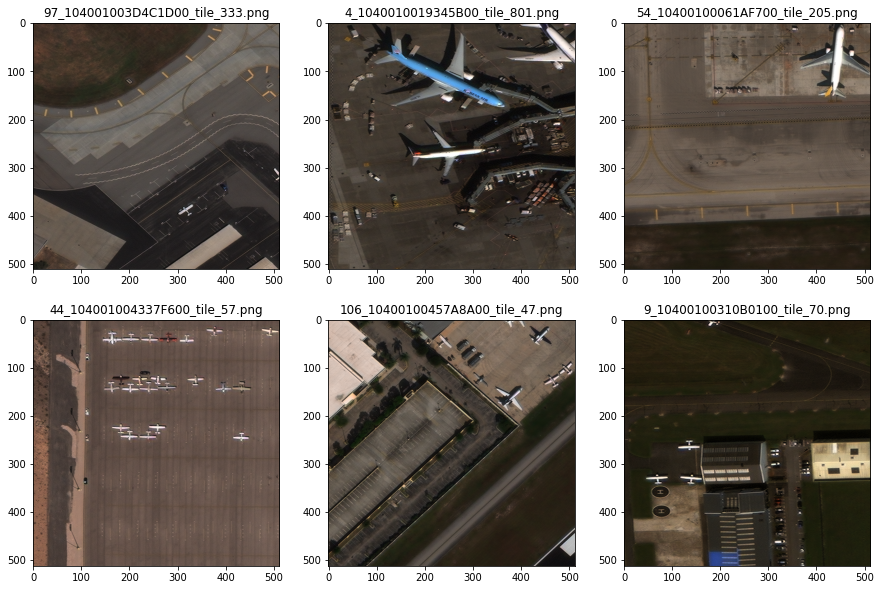

In [3]:
dir_tmp = train_imgs
rows, cols = 2, 3
figsize = 5
rand_selection = random.sample(train_im_list, rows*cols)
fig, axes = plt.subplots(nrows=rows, ncols=cols,  figsize=(figsize*cols, figsize*rows))
for i in range(rows*cols):
    ax = axes.flatten()[i]
    im_path_tmp = os.path.join(train_imgs, rand_selection[i])
    im_name_tmp = os.path.basename(im_path_tmp)
    im = skimage.io.imread(im_path_tmp)
    ax.imshow(im)
    ax.set_title(im_name_tmp)

# Loading the entire Dataset

In [4]:
print(len(train_im_list))
amount_imgs = 100

final_data, img_name_data = imgs_annot_aggregator(amount_imgs)#len(train_im_list))
result_data = bbox_points(final_data)

print(np.shape(result_data))

result_data.head()

5815
Running imgs_annot_aggregator...
Running bbox_points...
(308, 8)


,name,class,x_org,y_org,x_dist,y_dist,bbox,file_path
0,84_10400100290F5300_tile_178.png,Medium Civil Transport/Utility,293.230744,384.990839,96.973997,90.764739,"[293.230744343251, 384.99083873070776, 390.204...",d:\RarePlanes\data\train\84_10400100290F5300_t...
1,8_104001001051CB00_tile_68.png,Medium Civil Transport/Utility,252.669548,14.711575,64.923841,16.138212,"[252.6695484285592, 14.711574913933873, 317.59...",d:\RarePlanes\data\train\8_104001001051CB00_ti...
2,8_104001001051CB00_tile_68.png,Medium Civil Transport/Utility,296.817760,472.331903,23.929073,39.668097,"[296.8177600115305, 472.3319025337696, 320.746...",d:\RarePlanes\data\train\8_104001001051CB00_ti...
3,8_104001001051CB00_tile_68.png,Medium Civil Transport/Utility,310.173521,97.257601,23.743576,42.107748,"[310.17352149885846, 97.25760077126324, 333.91...",d:\RarePlanes\data\train\8_104001001051CB00_ti...
4,8_104001001051CB00_tile_68.png,Medium Civil Transport/Utility,304.423124,381.995016,38.026821,17.622185,"[304.4231241919915, 381.9950158111751, 342.449...",d:\RarePlanes\data\train\8_104001001051CB00_ti...


In [5]:
class_dict = {'Small Civil Transport/Utility': 0, 
              'Medium Civil Transport/Utility': 1, 
              'Large Civil Transport/Utility': 2, 
              "Military Transport/Utility/AWAC": 3,
              "Military Fighter/Interceptor/Attack": 4,
              "Military Bomber": 5,
              "Military Trainer": 6
              }

result_data['class'] = result_data['class'].apply(lambda x: class_dict[x])

In [6]:
result_data.head()

,name,class,x_org,y_org,x_dist,y_dist,bbox,file_path
0,84_10400100290F5300_tile_178.png,1,293.230744,384.990839,96.973997,90.764739,"[293.230744343251, 384.99083873070776, 390.204...",d:\RarePlanes\data\train\84_10400100290F5300_t...
1,8_104001001051CB00_tile_68.png,1,252.669548,14.711575,64.923841,16.138212,"[252.6695484285592, 14.711574913933873, 317.59...",d:\RarePlanes\data\train\8_104001001051CB00_ti...
2,8_104001001051CB00_tile_68.png,1,296.817760,472.331903,23.929073,39.668097,"[296.8177600115305, 472.3319025337696, 320.746...",d:\RarePlanes\data\train\8_104001001051CB00_ti...
3,8_104001001051CB00_tile_68.png,1,310.173521,97.257601,23.743576,42.107748,"[310.17352149885846, 97.25760077126324, 333.91...",d:\RarePlanes\data\train\8_104001001051CB00_ti...
4,8_104001001051CB00_tile_68.png,1,304.423124,381.995016,38.026821,17.622185,"[304.4231241919915, 381.9950158111751, 342.449...",d:\RarePlanes\data\train\8_104001001051CB00_ti...


In [7]:
def create_mask(bb, x):
    """Creates a mask for the bounding box of same shape as image"""
    rows,cols,*_ = x.shape
    Y = np.zeros([rows,cols])
    bb = bb.astype(int)
    Y[bb[1]:(bb[1]+bb[3]),bb[0]:(bb[0]+bb[2])] = 1.
    return Y

def create_bb_array(x):
    """Generates bounding box array from a train_df row"""
    return np.array([x[2],x[3],x[4],x[5]])

def mask_to_bb(Y):
    """Convert mask Y to a bounding box, assumes 0 as background nonzero object"""
    cols, rows = np.nonzero(Y)
    if len(cols)==0: 
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)

# Visualize Masks

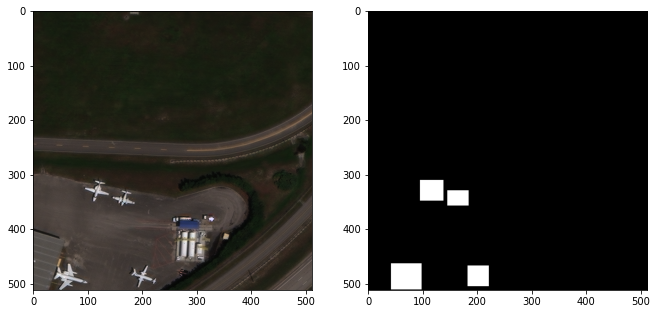

In [8]:
row = int(np.random.uniform(low=0, high=100, size=(1,)))

test_img = os.path.join(train_imgs, str(result_data['name'][row]))
rows_image = []

for i in range(100):    #len(train_im_list)):
    if result_data['name'][i] == result_data['name'][row]:
        rows_image.append(i)

im = skimage.io.imread(test_img)
bb = []
final_y = np.zeros((512,512))

for i in range(len(rows_image)):
    bb.append(create_bb_array(result_data.values[rows_image[i]]))
    Y = create_mask(bb[i],im)
    final_y = np.where(final_y == 0, Y, final_y)

figsize = 11
f, axarr = plt.subplots(1,2,figsize=(figsize*1, figsize*2))
axarr[0].imshow(im)
axarr[1].imshow(final_y, cmap='gray')

# Data Augmentation

In [9]:
new_size = 128
ratio = int(512/new_size)

def crop(im, r, c, target_r, target_c): 
    return im[r:r+target_r, c:c+target_c]

def random_crop(x, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)

def center_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)

def transformsXY(path, bb, transforms):
    x = cv2.imread(str(path)).astype(np.float32)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
    x = cv2.resize(x,(new_size,new_size) ) 
    bb[0] = int(bb[0]/ratio)
    bb[1] = int(bb[1]/ratio)
    bb[2] = int(bb[2]/ratio)
    bb[3] = int(bb[3]/ratio)
    return x, bb 

def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[0], bb[1]), bb[2]-bb[0], bb[3]-bb[1], color=color,
                         fill=False, lw=1)

def show_corner_bb(im, bb):
    plt.imshow(im)
    plt.gca().add_patch(create_corner_rect(bb))


In [10]:
result_data.head()

,name,class,x_org,y_org,x_dist,y_dist,bbox,file_path
0,84_10400100290F5300_tile_178.png,1,293.230744,384.990839,96.973997,90.764739,"[293.230744343251, 384.99083873070776, 390.204...",d:\RarePlanes\data\train\84_10400100290F5300_t...
1,8_104001001051CB00_tile_68.png,1,252.669548,14.711575,64.923841,16.138212,"[252.6695484285592, 14.711574913933873, 317.59...",d:\RarePlanes\data\train\8_104001001051CB00_ti...
2,8_104001001051CB00_tile_68.png,1,296.817760,472.331903,23.929073,39.668097,"[296.8177600115305, 472.3319025337696, 320.746...",d:\RarePlanes\data\train\8_104001001051CB00_ti...
3,8_104001001051CB00_tile_68.png,1,310.173521,97.257601,23.743576,42.107748,"[310.17352149885846, 97.25760077126324, 333.91...",d:\RarePlanes\data\train\8_104001001051CB00_ti...
4,8_104001001051CB00_tile_68.png,1,304.423124,381.995016,38.026821,17.622185,"[304.4231241919915, 381.9950158111751, 342.449...",d:\RarePlanes\data\train\8_104001001051CB00_ti...


d:\RarePlanes\data\train\113_10400100413CDF00_tile_54.png


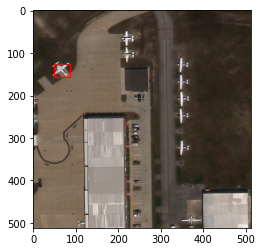

In [11]:
pic = int(np.random.uniform(low=0.0, high=100, size=None))

print(result_data['file_path'][pic])

im = cv2.imread(str(result_data['file_path'][pic]))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
show_corner_bb(im, result_data['bbox'][pic])

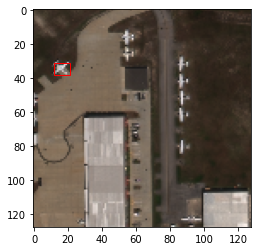

In [12]:
im, bb = transformsXY(str(result_data['file_path'][pic]), np.array(result_data['bbox'][pic],dtype=np.int32),True)
show_corner_bb(im, bb)

# Training


In [13]:
result_data = result_data.reset_index()

In [14]:
X = result_data[['file_path','bbox']]
Y = result_data['class']

X.head()

print(np.shape(X)[0])

308


In [15]:
Y.head()

0    1
1    1
2    1
3    1
4    1
Name: class, dtype: int64

# Pre Processing

#### Test image (reduced)

In [63]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def image_merger(result_data):
    final_data_frame = pd.DataFrame()
    print("Original length of result_data: ",len(result_data['file_path']))
    imgs_used = []

    for i in range(len(result_data['file_path'])):
        checker = True
        img_path_test = result_data['file_path'][i]

        for x in range(len(imgs_used)):
            if imgs_used[x] == img_path_test:
                checker = False
        
        if checker == True:
            imgs_used.append(img_path_test)
            indx_number = []

            for j in range(len(result_data['file_path'])):
                if img_path_test == result_data['file_path'][j]:
                    indx_number.append(j)

            final_bbxs = []
            for h in range(len(indx_number)):
                bbox = result_data['bbox'][indx_number[h]]
                final_bbxs.append(bbox)
            
            final_data_frame = final_data_frame.append({'path': img_path_test, 'final_bbx': final_bbxs}, ignore_index=True)

    return final_data_frame

df_final = image_merger(result_data)
df_final.head()

Original length of result_data:  308


,path,final_bbx
0,d:\RarePlanes\data\train\84_10400100290F5300_t...,"[[293.230744343251, 384.99083873070776, 390.20..."
1,d:\RarePlanes\data\train\8_104001001051CB00_ti...,"[[252.6695484285592, 14.711574913933873, 317.5..."
2,d:\RarePlanes\data\train\71_10400100379F8200_t...,"[[38.01601220294833, 347.1131749628112, 65.734..."
3,d:\RarePlanes\data\train\54_1040010042D13B00_t...,"[[182.98681181296706, 409.80085684452206, 320...."
4,d:\RarePlanes\data\train\109_104001003E4DC200_...,"[[288.8010251298547, 356.2977825384587, 317.23..."


### Function that outputs x,y points in the center of the s*s tiles

In [199]:
def reference_points_tiles(img_path,s): 
    im = cv2.imread(str(img_path))
    r,c, *_ = im.shape
    r_incr = int(r/s)
    c_incr = int(c/s)
    x = []
    y = []

    for i in range(0,c,r_incr):
        for j in range(0,r,c_incr):
            x.append(int(i+(c_incr/2)))
            y.append(int(j+(r_incr/2)))
    return x,y,s

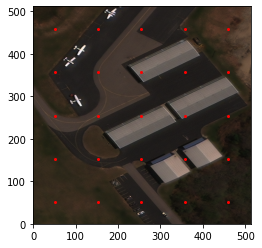

In [200]:
idx_image = 99
img_test_path_curr = df_final['path'][idx_image]


xs,ys,s = reference_points_tiles(img_test_path_curr,5)
im = skimage.io.imread(img_test_path_curr)

plt.figure()
plt.ylim(0,512)
plt.xlim(0,512)
plt.scatter(xs,ys, s=4, c='r')
plt.imshow(im)

### Function that generates bbox's based on a center point

In [285]:
class Bounding_boxes():
    def __init__(self,x1,y1,x2,y2):
        self.x1 = x1
        self.y1 = y1
        self.x2 = x2
        self.y2 = y2

    def calc(x1,y1,x2,y2):
        bbox = [x1,y1,x2,y2]
        return bbox


def bbox_gen(x,y,s):
    s = 1.0/s+2
    bbox1 = Bounding_boxes.calc(x-10,y-15,(x+10),(y+15))
    bbox2 = Bounding_boxes.calc(x-15,y-10,(x+15),(y+10))
    bbox3 = Bounding_boxes.calc(x-50,y-25,(x+50),(y+25))
    bbox4 = Bounding_boxes.calc(x-25,y-50,(x+25),(y+50))
    bbox5 = Bounding_boxes.calc(x-38,y-18,(x+38),(y+18))
    bbox6 = Bounding_boxes.calc(x-18,y-38,(x+18),(y+38))
    bbox7 = Bounding_boxes.calc(x-3,y-3,(x+3),(y+3))
    bbox8 = Bounding_boxes.calc(x-5,y-5,(x+5),(y+5))
    bbox9 = Bounding_boxes.calc(x-25,y-25,(x+25),(y+25))
    bbox10 = Bounding_boxes.calc(x-13,y-13,(x+13),(y+13))
    bbox11 = Bounding_boxes.calc(x-68,y-68,(x+68),(y+68))
    bbox12 = Bounding_boxes.calc(x-100,y-100,(x+100),(y+100))
    bbox13 = Bounding_boxes.calc(x-50,y-100,(x+50),(y+100))
    bbox14 = Bounding_boxes.calc(x-75,y-25,(x+75),(y+25))
    bbox15 = Bounding_boxes.calc(x-98,y-10,(x+98),(y+10))
    bbox16 = Bounding_boxes.calc(x-48,y-69,(x+48),(y+69))
    bbox17 = Bounding_boxes.calc(x-120,y-120,(x+120),(y+120))
    bbox18 = Bounding_boxes.calc(x-80,y-20,(x+80),(y+20))
    bbox19 = Bounding_boxes.calc(x-20,y-80,(x+20),(y+80))
    bbox20 = Bounding_boxes.calc(x-75,y-75,(x+75),(y+75))
    bbox21 = Bounding_boxes.calc(x-90,y-58,(x+90),(y+58))
    bbox22 = Bounding_boxes.calc(x-150,y-150,(x+150),(y+150))
    bbox23 = Bounding_boxes.calc(x-30,y-47,(x+30),(y+47))

    bbox = [bbox1,bbox2,bbox3,bbox4,bbox5,bbox6,bbox7,bbox8,bbox9,bbox10,bbox11,bbox12,bbox13,bbox14,bbox15,bbox16,bbox17,bbox18,bbox19,bbox20,bbox21,bbox22,bbox23]
    return bbox


51 51
[[41, 36, 61, 66], [36, 41, 66, 61], [1, 26, 101, 76], [26, 1, 76, 101], [13, 33, 89, 69], [33, 13, 69, 89], [48, 48, 54, 54], [46, 46, 56, 56], [26, 26, 76, 76], [38, 38, 64, 64], [-17, -17, 119, 119], [-49, -49, 151, 151], [1, -49, 101, 151], [-24, 26, 126, 76], [-47, 41, 149, 61], [3, -18, 99, 120], [-69, -69, 171, 171], [-29, 31, 131, 71], [31, -29, 71, 131], [-24, -24, 126, 126], [-39, -7, 141, 109], [-99, -99, 201, 201], [21, 4, 81, 98]]


<Figure size 432x288 with 0 Axes>

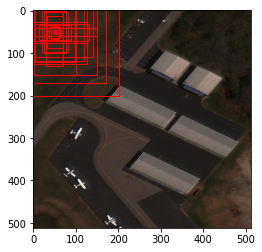

In [286]:
import matplotlib.patches as patches

print(xs[0], ys[0])
bboxes = bbox_gen(xs[0], ys[0],s)
print(bboxes)

# bboxs_list = []

# for i in range(len(xs)):
#     bbx = bbox_gen(xs[i],xs[i],s)
#     bboxs_list.append(bbx)

# Create figure and axes
plt.figure()
fig, ax = plt.subplots()
ax.scatter(xs[0],ys[0], s=4, c='r')
for i in range(len(bboxes)):
    ax.add_patch(patches.Rectangle((bboxes[i][0], bboxes[i][1]), bboxes[i][2]-bboxes[i][0], bboxes[i][3]-bboxes[i][1], color='r',fill=False, lw=1))
ax.imshow(im)

### IoU - Interception over Union

1.0


<Figure size 432x288 with 0 Axes>

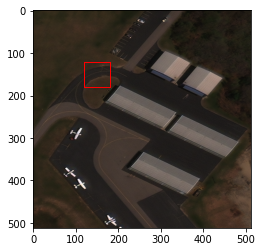

In [222]:
def iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou

rec1 = [120,120,120+60,120+60]
rec2 = [120,120,120+60,120+60]

result_iou = iou(rec1,rec2) 
print(result_iou)

plt.figure()
fig, ax = plt.subplots()
rect = patches.Rectangle((rec1[0], rec1[1]),rec1[2]-rec1[0], rec1[3]-rec1[1], color='r',fill=False, lw=1)
ax.add_patch(rect)
rect = patches.Rectangle((rec2[0], rec2[1]),rec2[2]-rec2[0], rec2[3]-rec2[1], color='r',fill=False, lw=1)
ax.add_patch(rect)
ax.imshow(im)

In [ ]:






def iou_calculator_img(image,idx,s):
    bboxs_list = []
    bbox = df_final['final_bbx'][idx]
    x,y,_ = reference_points_tiles(image,s)
    
    for i in range(len(x)):
        bbx = bbox_gen(x[i],y[i],s)
        bboxs_list.append(bbx)

    result_vector = []

    for i in range(len(bbox)):
        for j in range(len(bboxs_list)):
            for h in range(6):
                iou_result = iou(bbox[i],bboxs_list[j][h])
                result_vector.append(iou_result)

    return result_vector


#rv = iou_calculator_img(img_test_path_curr,idx_image,8)

#print(rv)


# Training

In [16]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

In [17]:
class AircraftDataset(Dataset):
    def __init__(self, paths, bb, y, transforms=False):
        self.paths = paths.values
        self.bb = bb.values
        self.y = y.values
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        path = self.paths[idx]
        y_class = self.y[idx]
        y_bb = self.bb[idx]
        x = self.paths
        x, y_bb = transformsXY(str(path), np.array(self.bb[idx],dtype=np.int32), True)
        x.transpose(1, 0, 2).strides        
        return x, y_class, y_bb

In [18]:
train_ds = AircraftDataset(X_train['file_path'],X_train['bbox'] ,y_train, transforms=True)
valid_ds = AircraftDataset(X_val['file_path'],X_val['bbox'],y_val)

In [19]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)


In [74]:
class BB_model(nn.Module):
    def __init__(self):
        super(BB_model, self).__init__()
        # resnet = models.resnet34(pretrained=True)
        # layers = list(resnet.children())[:8]
        # self.features1 = nn.Sequential(*layers[:6])
        # self.features2 = nn.Sequential(*layers[6:])
        self.conv1 = nn.Conv2d(3,6,3)
        self.classifier = nn.Sequential(nn.BatchNorm1d(6), nn.Linear(6, 7))
        self.bb = nn.Sequential(nn.BatchNorm1d(6), nn.Linear(6, 4))
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        return self.classifier(x), self.bb(x)


In [76]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
def create_model(num_classes):
    
    # load Faster RCNN pre-trained model
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # get the number of input features 
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # define a new head for the detector with required number of classes
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 
    return model

model = create_model(7)
print(model)

c:\Users\artur\anaconda3\envs\torch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\artur\anaconda3\envs\torch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to C:\Users\artur/.cache\torch\hub\checkpoints\fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100.0%


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [21]:
def update_optimizer(optimizer, lr):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = lr

In [22]:
def val_metrics(model, valid_dl, C=1000):
    count = 0
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0 
    for x, y_class, y_bb in valid_dl:
        print('Inside loop (val): ',count)
        batch = y_class.shape[0]
        x = x.float()
        x = torch.permute(x, (0, 3, 1, 2))
        y_class = y_class
        y_bb = y_bb.float()
        out_class, out_bb = model(x)
        loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
        loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
        loss_bb = loss_bb.sum()
        loss = loss_class + loss_bb/C
        _, pred = torch.max(out_class, 1)
        correct += pred.eq(y_class).sum().item()
        sum_loss += loss.item()
        total += batch
        count = count + 1 
    return sum_loss/total, correct/total

def train_epocs(model, optimizer, train_dl, val_dl, epochs=10,C=1000):
    idx = 0
    count = 0
    for i in range(epochs):
        print('Epoch number (train)',i,' of ', epochs)
        model.train()
        total = 0
        sum_loss = 0
        for x, y_class, y_bb in train_dl:
            print('Inside loop: ',count)
            batch = y_class.shape[0]
            x = x.float()
            y_class = y_class
            y_bb = y_bb.float()
            x = torch.permute(x, (0, 3, 1, 2))
            out_class, out_bb = model(x)
            loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
            loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
            loss_bb = loss_bb.sum()
            loss = loss_class + loss_bb/C
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            idx += 1
            total += batch
            sum_loss += loss.item()
            count = count + 1 
        train_loss = sum_loss/total
        val_loss, val_acc = val_metrics(model, valid_dl, C)
        print("train_loss %.3f val_loss %.3f val_acc %.3f" % (train_loss, val_loss, val_acc))
    return sum_loss/total


In [23]:
model = BB_model()
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.006)

In [24]:
train_epocs(model, optimizer, train_dl, valid_dl, epochs=2)

Epoch number (train) 0  of  2
Inside loop:  0
Inside loop:  1
Inside loop:  2
Inside loop:  3
Inside loop (val):  0
train_loss 3.024 val_loss 3.057 val_acc 0.052
Epoch number (train) 1  of  2
Inside loop:  4
Inside loop:  5
Inside loop:  6
Inside loop:  7
Inside loop (val):  0
train_loss 2.943 val_loss 3.025 val_acc 0.052


2.942796325683594